# 📈 AI Trading Bot – Advanced Starter Notebook

This notebook is a **clean, modern starter** for an AI-driven trading strategy. It includes:
- Data download with `yfinance`
- Feature engineering for a price-based model
- An advanced ML model (`HistGradientBoostingClassifier`)
- A simple **out-of-sample backtest** against buy & hold
- A current **model signal** for the latest data point

> ⚠️ **Educational use only.** This is not financial advice and not production-grade trading software.


## 1. Setup & Dependencies
If this is your first time running the notebook in this environment, uncomment and run the cell below to install requirements.

In [1]:
# Install dependencies if needed (uncomment and run once)
!pip install yfinance pandas scikit-learn matplotlib


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
python.exe -m pip install --upgrade pip

SyntaxError: invalid syntax (842801469.py, line 1)

## 2. Imports & Configuration
Set your **symbol**, **history length**, and **bar interval** here.

In [4]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import HistGradientBoostingClassifier

symbol = 'AAPL'      # Ticker to trade
period = '2y'        # Lookback period for history
interval = '1d'      # Bar interval (e.g. '1d', '1h', '15m')

symbol, period, interval

('AAPL', '2y', '1d')

## 3. Download & Inspect Market Data
We pull OHLCV data from Yahoo Finance using `yfinance`.

C:\Users\wkill\AppData\Local\Temp\ipykernel_37732\132612674.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, period=period, interval=interval)
[*********************100%***********************]  1 of 1 completed


Downloaded 502 bars for AAPL.


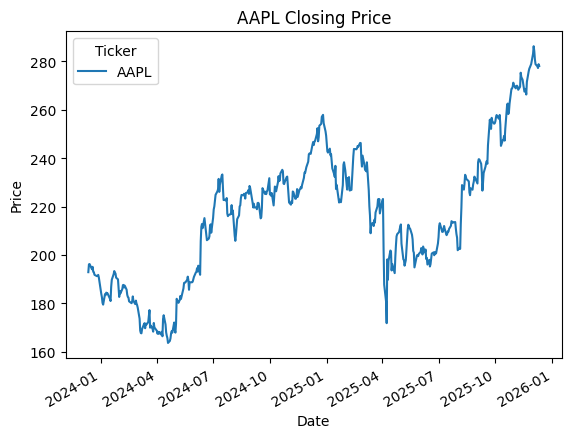

Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2025-12-05,278.779999,281.140015,278.049988,280.540009,47265800
2025-12-08,277.890015,279.670013,276.149994,278.130005,38211800
2025-12-09,277.179993,280.029999,276.920013,278.160004,32193300
2025-12-10,278.779999,279.750000,276.440002,277.750000,33038300
2025-12-11,278.029999,279.579987,273.809998,279.095001,30285187


In [5]:
df = yf.download(symbol, period=period, interval=interval)
df.dropna(inplace=True)
print(f"Downloaded {len(df)} bars for {symbol}.")

# Plot closing prices
ax = df['Close'].plot(title=f'{symbol} Closing Price')
ax.set_ylabel('Price')
plt.show()

df.tail()

## 4. Feature Engineering
We build a few simple technical features:
- Daily return
- Short and long moving averages (5 & 20 periods)
- Rolling volatility (10-period standard deviation)
- RSI (Relative Strength Index, 14 periods)

Our **target** is: `1` if the **next bar**'s return is positive, else `0`.

In [6]:
def compute_rsi(series, period: int = 14):
    delta = series.diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.rolling(window=period).mean()
    avg_loss = loss.rolling(window=period).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

# Base returns
df['Return'] = df['Close'].pct_change()

# Moving averages
df['SMA_5'] = df['Close'].rolling(window=5).mean()
df['SMA_20'] = df['Close'].rolling(window=20).mean()

# Volatility (10-bar std dev of returns)
df['Vol_10'] = df['Return'].rolling(window=10).std()

# RSI
df['RSI_14'] = compute_rsi(df['Close'], period=14)

# Target: will the next bar's return be positive?
df['Target'] = (df['Return'].shift(-1) > 0).astype(int)

df.dropna(inplace=True)

feature_cols = ['Close', 'SMA_5', 'SMA_20', 'Vol_10', 'RSI_14']
X = df[feature_cols]
y = df['Target']

df[feature_cols + ['Target']].tail()

Price,Close,SMA_5,SMA_20,Vol_10,RSI_14,Target
Ticker,AAPL,,,,,
Date,,,,,,
2025-12-05,278.779999,282.584003,274.756500,0.010921,58.909084,0
2025-12-08,277.890015,281.542004,275.240501,0.009760,66.456347,0
2025-12-09,277.179993,279.740002,275.628001,0.008509,65.040131,1
2025-12-10,278.779999,278.666003,275.804501,0.008616,65.550816,0
2025-12-11,278.029999,278.132001,276.032501,0.008662,68.817878,0


## 5. Train Advanced ML Model
We use `HistGradientBoostingClassifier`, a fast, powerful tree-based gradient boosting model from scikit-learn.

We split the data **by time** (first 70% train, last 30% test) to avoid lookahead bias from shuffling.

In [7]:
split_idx = int(len(df) * 0.7)

train = df.iloc[:split_idx].copy()
test = df.iloc[split_idx:].copy()

X_train, y_train = train[feature_cols], train['Target']
X_test, y_test = test[feature_cols], test['Target']

model = HistGradientBoostingClassifier(max_depth=3, max_iter=200)
model.fit(X_train, y_train)

train_score = model.score(X_train, y_train)
test_score = model.score(X_test, y_test)

print(f'Train accuracy: {train_score:.3f}')
print(f'Test accuracy:  {test_score:.3f}')

Train accuracy: 0.870
Test accuracy:  0.545


## 6. Simple Out-of-Sample Backtest
We simulate a basic strategy on the **test set only**:

- If the model predicts `1` (up), we are **long** for the next bar
- If the model predicts `0`, we are **flat** (no position)

Then we compare the equity curve vs simple **buy & hold** on the test period.

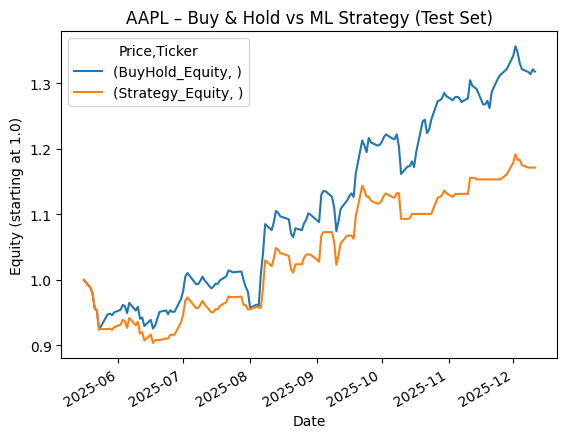

Buy & Hold final equity:  1.318
Strategy final equity:    1.171
Buy & Hold max drawdown:  -7.6%
Strategy max drawdown:    -9.7%
Approx. number of trades: 22


In [8]:
# Generate signals on test set
test = test.copy()
test['Signal'] = model.predict(X_test)

# Position applies to the NEXT bar
test['Position'] = test['Signal'].shift(1).fillna(0)

# Strategy returns: position * actual return
test['Strategy_Return'] = test['Position'] * test['Return']

# Equity curves
test['BuyHold_Equity'] = (1 + test['Return']).cumprod()
test['Strategy_Equity'] = (1 + test['Strategy_Return']).cumprod()

# Plot
ax = test[['BuyHold_Equity', 'Strategy_Equity']].plot(title=f'{symbol} – Buy & Hold vs ML Strategy (Test Set)')
ax.set_ylabel('Equity (starting at 1.0)')
plt.show()

def max_drawdown(equity):
    roll_max = equity.cummax()
    drawdown = equity / roll_max - 1.0
    return drawdown.min()

buyhold_final = test['BuyHold_Equity'].iloc[-1]
strategy_final = test['Strategy_Equity'].iloc[-1]

buyhold_dd = max_drawdown(test['BuyHold_Equity'])
strategy_dd = max_drawdown(test['Strategy_Equity'])

print('Buy & Hold final equity: ', round(buyhold_final, 3))
print('Strategy final equity:   ', round(strategy_final, 3))
print('Buy & Hold max drawdown: ', f'{buyhold_dd:.1%}')
print('Strategy max drawdown:   ', f'{strategy_dd:.1%}')

# Approximate trade count (position changes)
trade_count = int(test['Position'].diff().abs().sum() / 2)
print('Approx. number of trades:', trade_count)

## 7. Latest Model Signal
We use the **most recent row** of data to generate a directional signal.

In [9]:
latest_row = df.iloc[[-1]]  # keep as DataFrame
latest_features = latest_row[feature_cols]
latest_signal = model.predict(latest_features)[0]

print('Latest bar timestamp:', latest_row.index[0])
print('Latest close:        ', latest_row['Close'].iloc[0])
print('Model signal (next bar):', '📈 BUY / LONG' if latest_signal == 1 else '📉 FLAT / NO LONG')

Latest bar timestamp: 2025-12-11 00:00:00
Latest close:         Ticker
AAPL    278.029999
Name: 2025-12-11 00:00:00, dtype: float64
Model signal (next bar): 📈 BUY / LONG


## 8. Next Steps
Some ideas to evolve this notebook into a more serious project:

- Add **transaction costs** (commissions, slippage) to the backtest
- Use a **walk-forward** or expanding window backtest instead of a single split
- Add **position sizing** (risk per trade, volatility targeting)
- Export signals to a file or database for use with a live or paper trading engine
- Wrap the logic into functions/classes and move toward a multi-file project layout

From here, you can either keep iterating in this notebook or split pieces into a proper Python package / repo.